Notebook elaborado para apresentar uma breve introdução ao processamento de sinais.
Criado para a disciplina Geofísica I da Universidade Federal de Uberlândia.
O uso e a reprodução são livres para fins educacionais, pede-se apenas a citação da fonte.

[![License: GPL v3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

Prof. Dr. Emerson Rodrigo Almeida<br>
Universidade Federal de Uberlândia<br>
Instituto de Geografia - Curso de Geologia<br>
[emerson.almeida@ufu.br](mailto:emerson.almeida@ufu.br)<br>

<p>&nbsp;</p>
Última modificação: 11/02/2021

# Instruções iniciais

Neste notebook você irá elaborar curvas de resistividade aparente para Sondagens Elétricas Verticais (SEVs) em diferentes arranjos, verificando os efeitos de cada um sobre as curvas de dados. Para isto **leia atentamente** as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

 
# Passo 01 - Preparação

Primeiramente vamos preparar o notebook com os pacotes, módulos e funções que precisaremos no decorrer da demonstração. A célula abaixo executa a instalação do pacote open sourece [SimPEG](https://docs.simpeg.xyz/), responsável por executar os cálculos relacionados à física do problema. Se você está executando este notebook no MyBinder ou no Google Colab não se preocupe, nada será instalado na sua máquina local. Execute esta célula uma vez antes de executar qualquer outra parte do código e não altere nada no código apresentado na célula para não criar problemas na execução do código.

Você pode executar o código na célula clicando sobre ela e em seguida clicando no botão **RUN** na barra do Jupyter Notebook ou pressionando as teclas **SHIFT+ENTER** no seu teclado. A execução desta primeira célula pode demorar um pouco, pois um pacote inteiro estará sendo instalado. Aguarde o término da instalação antes de executar a célula seguinte.

<p>&nbsp;</p>

**Importante!** Nem todas as células de código desta demostração irão retornar algum tipo de mensagem ou figura após a execução. Isto é normal e não significa que a execução tenha falhado. Perceba o símbolo **In [ ]:** próximo ao canto superior esquerdo de cada célula. Ao iniciar a execução de uma delas você verá um asterisco ($*$) aparecer dentro dos colchetes. Você saberá que a execução ocorreu sem problemas quando o $*$ dentro dos colchetes for substituído por um número e nenhuma mensagem de erro aparecer abaixo da célula executada.

# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto

# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_fwd_1_dcr_sounding.html#sphx-glr-content-tutorials-05-dcr-plot-fwd-1-dcr-sounding-py

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt
!python setup.py install

In [ ]:
# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto

# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_fwd_1_dcr_sounding.html#sphx-glr-content-tutorials-05-dcr-plot-fwd-1-dcr-sounding-py

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt
!python setup.py install

fatal: destination path 'simpeg' already exists and is not an empty directory.
/content/simpeg
Obtaining file:///content/simpeg (from -r requirements.txt (line 1))
  Found existing installation: SimPEG 0.14.3
    Uninstalling SimPEG-0.14.3:
      Successfully uninstalled SimPEG-0.14.3
  Running setup.py develop for SimPEG
running install
running bdist_egg
running egg_info
writing SimPEG.egg-info/PKG-INFO
writing dependency_links to SimPEG.egg-info/dependency_links.txt
writing requirements to SimPEG.egg-info/requires.txt
writing top-level names to SimPEG.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'SimPEG.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/SimPEG
creating build/bdist.linux-x86_64/egg/SimPEG/regularization
copying build/lib/SimPEG/regularization/regularization_mesh.py -> build/bdist.linux-x86_6

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from discretize import TensorMesh

from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import plot_layer

tendcurva = False  # para uso com o exercício 2

class sev():

    """
    Sondagem Elétrica Vertical configurada de acordo com
    os parâmetros necessários para uso com o SimPEG
    """

    def __init__(self, meioAB, meioMN, arranjo):

        if len(meioAB)>len(meioMN):
            print("\nERRO: número de posições de AB/2 é maior do número de "
                "posições de MN/2.\n")
            return None
          
        elif len(meioAB)<len(meioMN):
            print("\nERRO: número de posições de AB/2 é menor do número de "
                "posições de MN/2.\n")
            return None

        else:
            self.arranjo = arranjo
            self.meioAB = meioAB      # distâncias de AB/2
            self.meioMN = meioMN      # distâncias de MN/2
            source_list = []

            for ii in range(len(meioAB)):
                A = np.r_[-1 * meioAB[ii], 0.0,0.0]
                B = np.r_[meioAB[ii], 0.0,0.0]
                M = np.r_[-1 * meioMN[ii], 0.0,0.0]
                N = np.r_[meioMN[ii], 0.0,0.0]

                receiver_list = [dc.receivers.Dipole(M, N)]
                source_list.append(dc.sources.Dipole(receiver_list, A, B))

            self.survey = dc.Survey(source_list)

            # inicializa sem nada porque ainda não foi feita a modelagem
            self.rho_a = None


    def fwd(self, modelo):

        """
        Executa a modelagem com os parâmetros definidos para a SEV
        """

        simulation = dc.simulation_1d.Simulation1DLayers(
                      survey = self.survey,
                      rhoMap = modelo.model_map,
                      thicknesses = modelo.h,
                      data_type = "apparent_resistivity"
                      )

        self.rho_a = simulation.dpred(modelo.rho)


class modelo_geo():
    """
    Modelo Geoelétrico 1-D a ser modelado
    """
    
    def __init__(self, rho, h):

        self.rho = rho
        self.h = h
        self.z_max = np.sum(self.h) * 1.3

        # Define mapping from model to 1D layers
        self.model_map = maps.IdentityMap(nP=len(self.rho))


    def mostra_grafico(self, n_fig='X'):
        """
        Método para plotar o modelo
        """
        
        # Define a malha 1D
        mesh = TensorMesh([np.r_[self.h, self.z_max - self.h.sum()]])

        fig, ax1 = plt.subplots(figsize=(4,4))
        plot_layer(self.model_map * self.rho, mesh, xlim=[10, 1e4], \
                   ax=ax1, showlayers=False)

        ax1.set_xlabel('Resistividade Real (Ohm.m)')
        ax1.set_ylabel('Profundidade (m)')
        ax1.set_title('Figura ' + n_fig + '. Modelo de n=' + \
                      str(len(self.rho)) + ' camadas')
        ax1.grid(which='both')
        plt.show()


def calcula_tendencias(sondagem, modelo):
    """
    Calcula a tendência da curva de resistividade aparente para cada
    camada individualmente, como se a camada correspondesse ao semi-espaço
    homogêneo de resistividade correspondente à resistividade da camada
    sendo considerada.
    
    Utiliza as configurações da sondagem fornecida para executar o cálculo
    do problema direto N-1 vezes, onde N é o número de camadas do modelo
    fornecido. A execução começa com um modelo de uma única camada, e as
    camadas são consideradas na modelagem gradativamente, uma a uma.
    """
    
    rho_a_list = []
    sev_parcial = deepcopy(sondagem)

    for ii in range(0, len(modelo.rho)-1):

        if ii==0:
            # Faz um modelo de duas camadas de resistividades iguais
            # para simular um semi-espaço homogêneo.
            res = np.r_[resistividades[:ii+1], resistividades[:ii+1]]
            esp = espessuras[:ii+1]

        else:
            # Cria modelos com aumento gradual do número de camadas 
            res = resistividades[:ii+1]
            esp = espessuras[:ii]

        modelo_parcial = modelo_geo(res, esp)
        sev_parcial.fwd(modelo_parcial)
        rho_a_list.append(sev_parcial.rho_a)

    return rho_a_list


def plota_sondagem(sondagem, modelo, tendencias=False, n_fig='X'):
    
    """
    Exibe a curva de resistividade aparente resultante da modelagem
    """
  
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    # insere as curvas com as tendências da resistividade aparente
    if tendencias:
        curvas = calcula_tendencias(sondagem, modelo)
        cor = ['--r', '--y', '--c', '--k', '--m', '-.r', '-.y', \
               '-.c', '-.k', '-.m']
        
        for n in range(len(curvas)):
            ax[0].loglog(sondagem.meioAB, curvas[n], cor[n], \
                         label='n = ' + str(n+1))
          
        ax[0].loglog(sondagem.meioAB, sondagem.rho_a, '-b', \
                     label='n = ' + str(n+2))
        ax[0].legend(loc='upper right')
    
    else:
        ax[0].loglog(sondagem.meioAB, sondagem.rho_a, '-b')
    
    ax[0].plot(sondagem.meioAB, sondagem.rho_a, 'ok')
    ax[0].set_xlabel('AB/2 (m)', fontsize='14')
    ax[0].set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
    ax[0].set_title('Figura ' + n_fig + 'a. Sondagem ' + sondagem.arranjo, \
                    fontsize='14')
    ax[0].set_ylim([10, 1000])
    ax[0].set_xlim([1, 1000])
    ax[0].grid(which='both')
    
    mesh = TensorMesh([np.r_[modelo.h, modelo.z_max - modelo.h.sum()]])
    plot_layer(modelo.model_map * modelo.rho, mesh, xlim=[10, 1e4], \
                ax=ax[1], showlayers=False)
    ax[1].set_xlabel('Resistividade Real (Ohm.m)')
    ax[1].set_ylabel('Profundidade (m)')
    ax[1].set_title('Figura ' + n_fig + 'b. Modelo de n=' + \
                    str(len(modelo.rho)) + ' camadas', fontsize='14')
    ax[1].grid(which='both')

    plt.show()


def compara_sevs(sev1, sev2, n_fig='X'):
    
    """
    Exibe uma figura para comparação entre duas sondagens diferentes
    """

    fig, ax1 = plt.subplots(figsize=(7, 7))
    
    ax1.loglog(sev1.meioAB, sev1.rho_a, '-ob', label=sev1.arranjo)
    ax1.loglog(sev2.meioAB, sev2.rho_a, '-or', label=sev2.arranjo)
    ax1.set_xlabel('AB/2 (m)', fontsize='14')
    ax1.set_ylabel('Resistividade Aparente ($\Omega$.m)', fontsize='14')
    ax1.set_title('Figura ' + n_fig + '. Comparação entre curvas de SEVs', \
                  fontsize='14')
    ax1.set_ylim([10, 1000])
    ax1.legend(loc='upper right')
    ax1.grid(which='both')
    plt.show()

# Passo 02 - Configuração do modelo geoelétrico

A modelagem requer que seja fornecido um modelo geoelétrico, portanto vamos criá-lo aqui. Lembre-se de que o modelo geoelétrico apresenta os principais contrastes de resistividade, cujas profundidades podem coincidir com as profundidades dos contatos geológicos ou não.

Vamos definir um modelo de 04 camadas. Execute a célula abaixo para criar o modelo

In [12]:
# modelo 1D
resistividades = np.r_[50.0, 300.0, 30.0, 1000]
espessuras = np.r_[4.0, 4.0, 30.0]

e execute a célula abaixo para visualizá-lo. Esta é a forma mais comum de se apresentar um modelo geoelétrico, não apenas para sondagens elétricas mas também para sondagens eletromagnéticas.

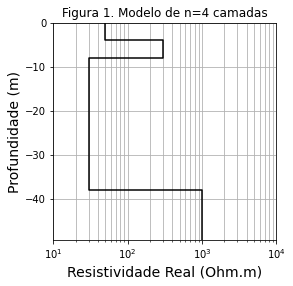

In [13]:
meu_modelo = modelo_geo(resistividades, espessuras)
meu_modelo.mostra_grafico(n_fig='1')

# Passo 03 - Aberturas dos eletrodos de corrente (A e B)

Vamos agora configurar a SEV em si. Para isto é necessário definir quais são as posições dos eletrodos de injeção de corrente elétrica (A e B) e dos eletrodos de medição de potencial elétrico (M e N). Como os arranjos das SEVs são sempre simétricos é comum definir-se a posição dos eletrodos em relação ao ponto central da sondagem, de forma que define-se a meia distância entre os eletrodos A e B (AB/2) e a meia distância entre os eletrodos M e N (MN/2).

O que difere uma SEV em arranjo Schlumberger de uma SEV em arranjo Wenner é o posicionamento dos eletrodos de medida de potencial, enquanto as posições dos eletrodos de injeção de corrente podem iguais para ambos. Execute a célula abaixo para configurar as meias distâncias correspondentes às posições dos eletrodos A e B.

In [14]:
eletrodos_AB = np.array([1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, \
                         15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 80.0, \
                         100.0, 150.0, 200.0])

# Passo 04 - SEV com arranjo Wenner

Vamos agora configurar as posições dos eletrodos de medição do potencial para uma sondagem em arranjo Wenner. Neste arranjo as distâncias AM, MN e NB são idênticas, então as posições de M e N podem ser obtidas a partir das posições de A e B ou vice-versa. Aqui iremos calcular as posições de M e N a partir das posições de A e B, o que corresponde às posições de AB/2 e MN/2 em termos de meias-distâncias. Assim, pode-se definir que $(MN)/2 = (1/3) \times (AB)/2$ (verifique graficamente esta relação).

Execute a célula abaixo para configurar as posições dos eletrodos.

In [16]:
eletrodos_MN_wenner = np.array([0.50, 0.67, 1.00, 1.30, 1.67, 2.00, 2.67,  \
                                3.33, 4.00, 5.00, 6.67, 8.33, 10.00, 13.33, \
                                16.67, 20.00, 26.67, 33.33, 50.00, 66.67])

e execute a célula abaixo para executar a SEV com as posições de eletrodos configuradas.

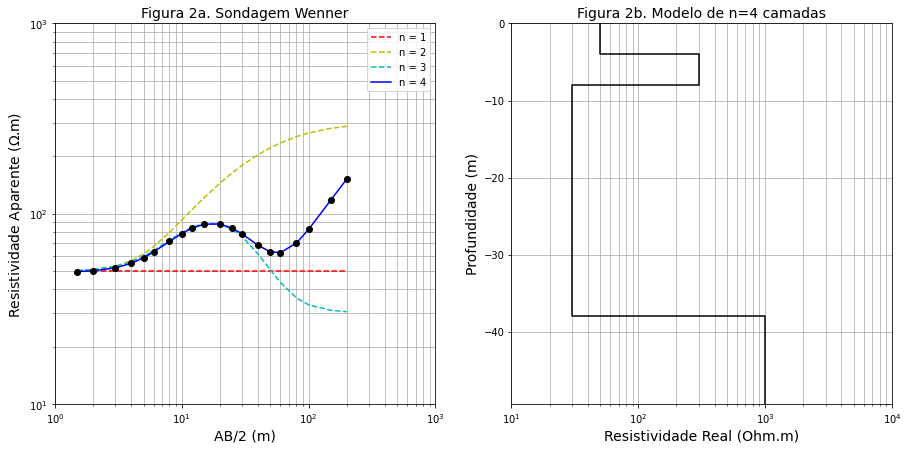

In [43]:
sev_w = sev(eletrodos_AB, eletrodos_MN_wenner, 'Wenner')
sev_w.fwd(meu_modelo)
plota_sondagem(sev_w, meu_modelo, tendencias=tendcurva, n_fig='2')

# Passo 05 - SEV com arranjo Schlumberger

Vamos agora configurar uma SEV com arranjo Schlumberger. Neste arranjo o afastamento entre os eletrodos M e N deve idealmente obedecer à relação $AB \ge 5 \times MN$, embora em campo seja um pouco difícil manter esta relação para pequenos afastamentos. Nesta demonstração iremos considerar condição limite para a relação entre as disâncias AB e MN, utilizando a relação de $MN/2 = (1/5) \times AB/2$. Em campo costuma-se repetir uma mesma posição de M e N para várias posições de A e B, fazendo desta a principal vantagem logístca do arranjo Schlumberger em campo. Neste caso utiliza-se como critério para aumento da distância MN o valor do potencial lido, de forma que a distância deve ser aumentada sempre que o potencial lido ficar muito próximo do nível de ruído.

Execute a célula abaixo para definir os novos espaçamentos entre eletrodos M e N.

In [45]:
eletrodos_MN_schlumberger = np.array([0.3, 0.4, 0.6, 0.8, 1.0, 1.2, 1.6, \
                                      2.0, 2.4, 3.0, 4.0, 5.0, 6.0, 8.0, \
                                      10.0, 12.0, 16.0, 20.0, 30.0, 40.0])

e execute a célula abaixo para obter a curva de resistividade aparente referente a esta modelagem.

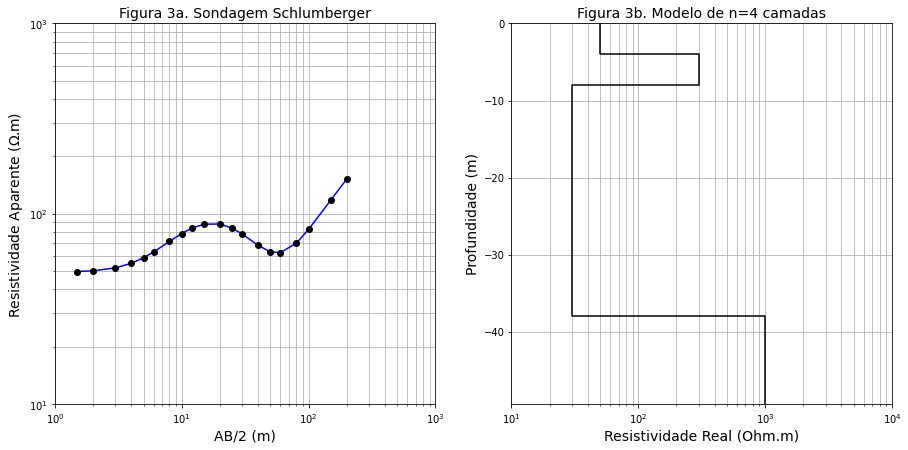

In [48]:
sev_s = sev(eletrodos_AB, eletrodos_MN_schlumberger, 'Schlumberger')
sev_s.fwd(meu_modelo)
plota_sondagem(sev_s, meu_modelo, tendencias=tendcurva, n_fig='3')

# Passo 06 - Comparação entre as SEVs

Execute a célula abaixo para visualizar uma comparação entre as sondagens modeladas com ambos os arranjos

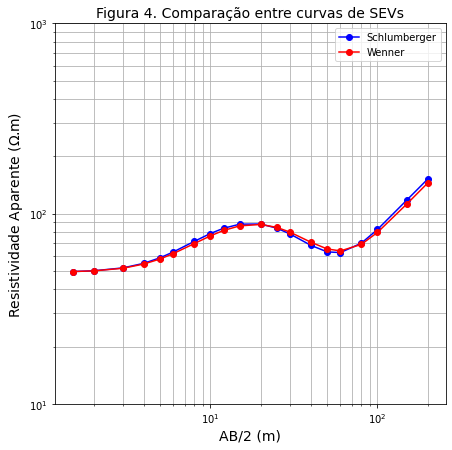

In [40]:
compara_sevs(sev_s, sev_w, n_fig='4')

# Exercícios

**1-** Como você explica a sutil diferença entre as curvas da Figura 4 se o modelo geoelétrico é o mesmo em ambas as sondagens?

**2-** Execute a célula abaixo para habilitar um componente gráfico adicional nas curvas de resistividade aparente:

In [41]:
# Atua como uma "chave" ON/OFF dos componentes gráficos adicionais, mudando 
# de estado cada vez que esta célula é executada.
tendcurva = not tendcurva

Agora execute novamente a segunda célula do Passo 04 e a segunda célula do Passo 05. Observe as linhas tracejadas nas Figuras 2a e 3a. Explique a tendência apresentada por estas curvas em relação ao modelo geoelétrico (Figuras 2b e 3b) e o que elas se comportam desta maneira.

**3-** Insira pontos extras de aquisição de dados tanto na sondagem Wenner quanto na sondagem Schlumberger. Comece incluindo pontos intermediários na primeira década de AB/2, em seguida insira pontos intermediários na segunda década, e por fim insira pontos intermediários na terceira década. Note que as distâncias de AB/2 serão as mesmas para ambos os arranjos, mas você precisará calcular as posições dos eletrodos M e N correspondentes de forma adequada ou sua resposta poderá ser dada de forma incorreta. Que diferenças você observa no comportamento geral da curva de resistividade aparente? Por quê?

Se preferir, execute a célula do exercício 2 novamente para desabilitar os componentes gráficos inseridos no exercício anterior.

**4-** Acrescente pontos extras ao final de ambas as sondagens. Quantos pontos extras você precisa incluir para que a curva de resistividade aparente comece a convergir para a resistividade do semi-espaço homogêneo?